### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

### Data importing

In [2]:
train = pd.read_csv(r'C:\Users\Prashant\Downloads\train_Df64byy.csv')
test = pd.read_csv(r'C:\Users\Prashant\Downloads\test_YCcRUnU.csv')

In [3]:
train.head(4)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0


In [4]:
train.isnull().sum() #checking for the null values in the train dataset

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

### Data cleaning & structuring for training set

In [5]:
# encoding of training set

enc = OrdinalEncoder() 
train.loc[train['Health Indicator'].notna(), ['Health Indicator']] = enc.fit_transform(train["Health Indicator"].dropna().values.reshape(-1,1)) #ordinal encoding of string features

enc1 = OrdinalEncoder()
train['City_Code'] = enc1.fit_transform(train['City_Code'].values.reshape(-1,1))

def binary_assign(x):      # function to assign boolean values to different features of dataset
    if x in ['Owned', 'Individual', 'Yes']:
        return 1
    else:
        return 0

train['Accomodation_Type'] = train['Accomodation_Type'].apply(binary_assign)
train['Reco_Insurance_Type'] = train['Reco_Insurance_Type'].apply(binary_assign)
train['Is_Spouse'] = train['Is_Spouse'].apply(binary_assign)

def str_to_val(x): #function to impute '14+' string to a numerical value
    if x == '14+':
        return 15
    else:
        return x

train['Holding_Policy_Duration'] = train['Holding_Policy_Duration'].apply(str_to_val)

In [6]:
# missing values imputation for training set
#Used iterative imputer to impute missing values iteratively 

imp0 = IterativeImputer(max_iter=10, random_state=0) 
train['Holding_Policy_Type'] = np.round(imp0.fit_transform(train["Holding_Policy_Type"].values.reshape(-1,2))).reshape(50882,) #reshaping the array 

imp = IterativeImputer(max_iter=10, random_state=0)
train['Health Indicator'] = np.round(imp.fit_transform(train["Health Indicator"].values.reshape(-1,2))).reshape(50882,)

imp1 = IterativeImputer(max_iter=10, random_state=0)
train['Holding_Policy_Duration'] = np.round(imp1.fit_transform(train['Holding_Policy_Duration'].values.reshape(-1,2))).reshape(50882,)



In [7]:
final_train=train #final train data to work with 

### Data cleaning & structuring for testing set

In [8]:
# encoding of testing set

enc2 = OrdinalEncoder()
test.loc[test['Health Indicator'].notna(), ['Health Indicator']] = enc2.fit_transform(test["Health Indicator"].dropna().values.reshape(-1,1)) #ordinal encoding of string features

enc3 = OrdinalEncoder()
test['City_Code'] = enc3.fit_transform(test['City_Code'].values.reshape(-1,1))

test['Accomodation_Type'] = test['Accomodation_Type'].apply(binary_assign) # using binary assign function convert the string values to boolean vals 
test['Reco_Insurance_Type'] = test['Reco_Insurance_Type'].apply(binary_assign)
test['Is_Spouse'] = test['Is_Spouse'].apply(binary_assign)


test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].apply(str_to_val) #using str_to_val function to convert the '14+' string to int(15)

In [9]:
test.loc[len(test.index)] = [0,0,0,0,0,0,0,0,0,0,0,0,0] #appending extra row in test to fit the imputer object 

In [10]:
# missing values imputation for testing set
#Used iterative imputer to impute missing values iteratively 


imp2 = IterativeImputer(max_iter=10, random_state=0)
test['Holding_Policy_Type'] = np.round(imp2.fit_transform(test["Holding_Policy_Type"].values.reshape(-1,2))).reshape(21806,)

imp3 = IterativeImputer(max_iter=10, random_state=0)
test['Health Indicator'] = np.round(imp3.fit_transform(test["Health Indicator"].values.reshape(-1,2))).reshape(21806,)

imp4 = IterativeImputer(max_iter=10, random_state=0)
test['Holding_Policy_Duration'] = np.round(imp4.fit_transform(test['Holding_Policy_Duration'].values.reshape(-1,2))).reshape(21806,)

In [11]:
final_test = test.drop([21805]) #final test dataset is obtained to work with 

#### EDA

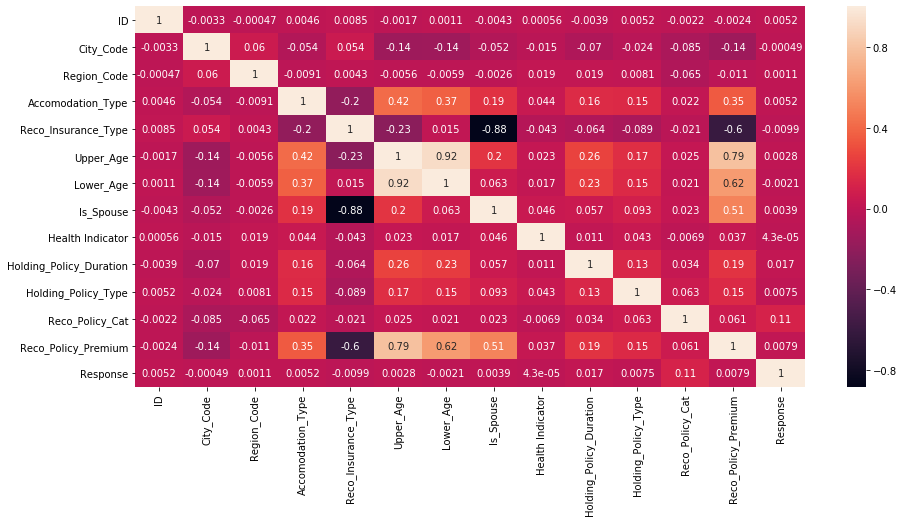

In [12]:
plt.figure(figsize=(15,7))
sns.heatmap(final_train.corr(method='pearson'),annot=True)

# There is a very high correlation(0.92) between upper age & lower age as for many cases only 1 induvidual is there instead of 2 or more
# There's also a very strong +ve correlation between upper age & Reco_policy_premium as more aged people are more prone to diseases hence require better premium policies
# There's also avg +ve correlation between is_spouse & Reco_policy_premium as it's always better to buy a premium policy if an individual have people who depend on them

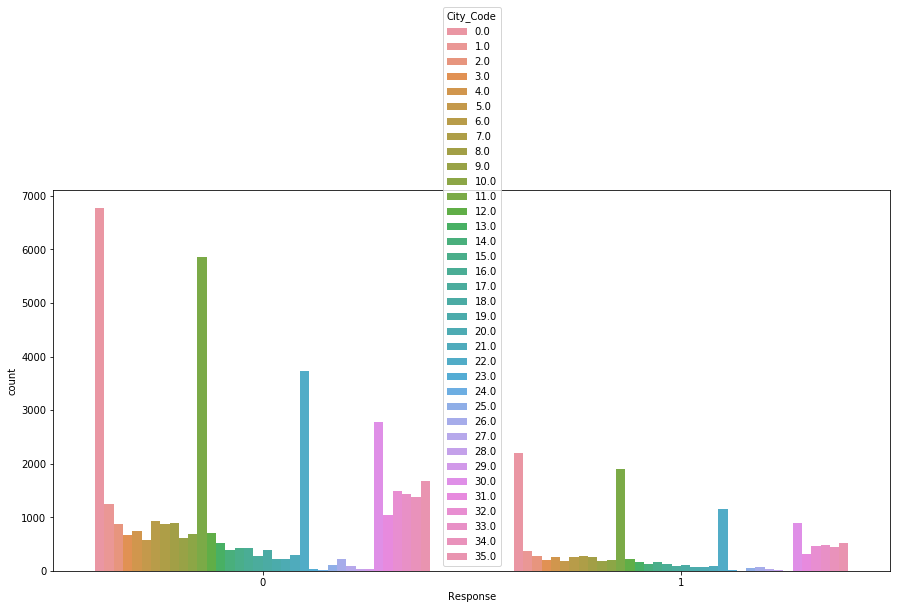

In [13]:
plt.figure(figsize=(15,7))
sns.countplot(x='Response',data=final_train,hue='City_Code')

# Majority of individuals from city codes 0-2,11-12,30 showed no response for health policy
# Out of all positive responses i.e 1, individuals from city code 0 are highest in number simply because of large sample size of people residing in that particular city

Text(0.5, 0, 'Accomodation type(1-owned & 0-rented)')

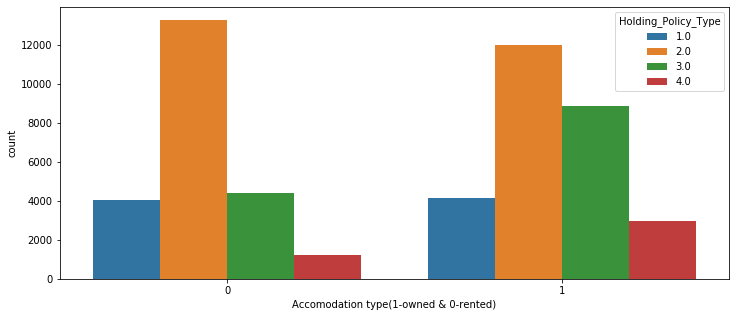

In [14]:
plt.figure(figsize=(12,5))
sns.countplot(x=final_train.Accomodation_Type,data=final_train,hue='Holding_Policy_Type')
plt.xlabel('Accomodation type(1-owned & 0-rented)')

# People with holding policy type=1 are largest in number.
# People with holding policy type=1 are significantly interested & not interested in the health policy as difference between no of individuals  

Text(0.5, 0, 'Health indicator')

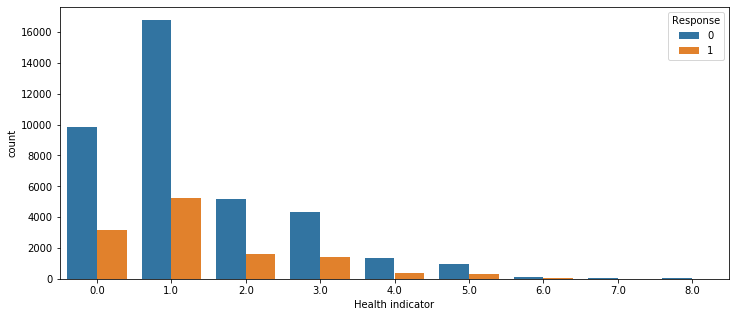

In [15]:
plt.figure(figsize=(12,5))
sns.countplot(x=final_train['Health Indicator'],data=final_train,hue='Response')
plt.xlabel('Health indicator')

# People with health indicator=1 showed the highest positive response to the recommended policy among all individuals with different health indicators  

(2000, 40000)

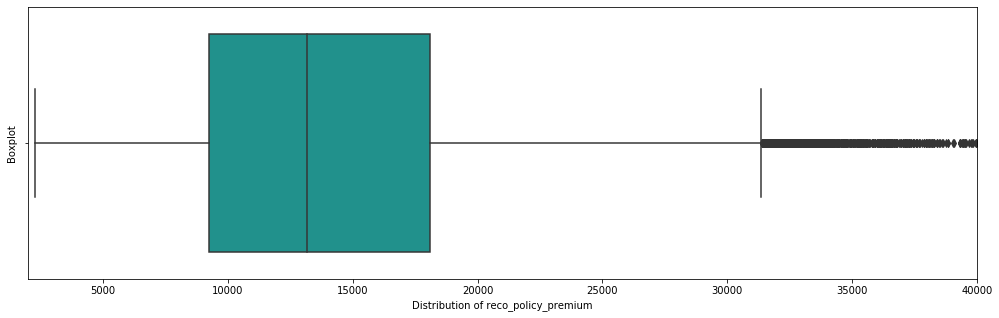

In [16]:
plt.figure(figsize=(17,5))
sns.boxplot(x='Reco_Policy_Premium',data=final_train,saturation=50,palette='viridis')
plt.xlabel('Distribution of reco_policy_premium')
plt.ylabel('Boxplot')
plt.xlim(2000,40000)

# The INR values spent over 32k are considered as an outlier as majority of people in distribution spends money less than 32k on health policy 

### Model building & prototyping

#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Best prediction so far ................

#### Voting regressor is the 2nd best approach so far that I've tried

In [17]:
# differentiating between the dependent & independent features

X = final_train.drop(labels='Response',axis=1)
y = final_train['Response']

In [18]:
# Using randomizedsearchCV for findind & tuning the best set of parameters for the specific estimator 
# Using random forest regressor for prediction 

random_search = {'criterion': ['mse'],
               'max_depth': [2,3,4,5,6,7,10],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5,7,10],
               'n_estimators': [200]}

reg = RandomForestRegressor()
model = RandomizedSearchCV(estimator = reg, param_distributions = random_search, n_iter = 10,
                            cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
print(model.fit(X,y))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.5min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [19]:
model.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 8,
 'max_depth': 10,
 'criterion': 'mse'}

In [20]:
# Using randomizedsearchCV for findind & tuning the best set of parameters for the specific estimator 
# gradient boosting

random_search1 = {'criterion': ['friedman_mse'],
                  'max_depth': [2,3,4,5,6,7,10],
                  'min_samples_leaf': [4, 6, 8],
                  'min_samples_split': [5,7,10],
                  'n_estimators': [200],
                  'learning_rate':[0.1,0.5,1.0]
                }

gb = GradientBoostingRegressor()
model1 = RandomizedSearchCV(estimator = gb, param_distributions = random_search1, n_iter = 10,
                            cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
print(model1.fit(X,y))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.4min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [21]:
model1.best_params_

{'n_estimators': 200,
 'min_samples_split': 7,
 'min_samples_leaf': 8,
 'max_depth': 5,
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

In [22]:
# Using randomizedsearchCV for findind & tuning the best set of parameters for the specific estimator 
# ada boosting

random_search2 = {'random_state': [0,1,10,40,50,100,None],
                  'loss': ['linear', 'square'],
                  'n_estimators': [100,200,300],
                  'learning_rate':[0.1,0.5,1.0]
                }

ada = AdaBoostRegressor()
model2 = RandomizedSearchCV(estimator = ada, param_distributions = random_search2, n_iter = 10,
                            cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
print(model2.fit(X,y))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=None,
                                               learning_rate=1.0, loss='linear',
                                               n_estimators=50,
                                               random_state=None),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.5, 1.0],
                                        'loss': ['linear', 'square'],
                                        'n_estimators': [100, 200, 300],
                                        'random_state': [0, 1, 10, 40, 50, 100,
                                                         None]},
                   pre_dispatch='2*n_jobs', random_state=101, refit=True,
                   return_train_score=False, scoring=None, verbose=1)


In [23]:
model2.best_params_ #best parameters for the model deployment

{'random_state': 1,
 'n_estimators': 100,
 'loss': 'linear',
 'learning_rate': 0.1}

In [24]:
# after finding the best set of tuned parameters for different estimators, here I used the best set of hyperparameters for making the final model

clf = RandomForestRegressor(n_estimators=200,
                            min_samples_split= 5,
                            min_samples_leaf= 8,
                            max_depth= 10,
                            criterion= 'mse'
                           )

gb = GradientBoostingRegressor(n_estimators= 200,
                               min_samples_split= 7,
                               min_samples_leaf= 8,
                               max_depth= 5,
                               learning_rate= 0.1,
                               criterion= 'friedman_mse'
                              )


ada = AdaBoostRegressor(random_state= 1,
                        n_estimators= 100,
                        loss= 'linear',
                        learning_rate= 0.1)

In [25]:
# A voting regressor is an ensemble meta-estimator that fits base
#regressors each on the whole dataset. It, then, averages the individual
#predictions to form a final prediction.

# Inserting all tuned estimators in the voting regressor which yeilds the avg of results of individual models when fitted to data

voting_reg = VotingRegressor(estimators=[('clf', clf), ('gbrt', gb),('ada',ada)], n_jobs= -1)
voting_reg.fit(X, y)

VotingRegressor(estimators=[('clf',
                             RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=10,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=8,
                                                   min_samples_split=5,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=200,
                                                   n_jobs=None, oob_score=False,
                                                   random_state=None, verbose=0,
           

In [26]:
y_predo = voting_reg.predict(final_test) #prediction array

In [27]:
predictions = pd.DataFrame(data=y_predo,columns=['Response'])
result = pd.concat([final_test['ID'], predictions],axis=1)

result.to_csv(r'C:\Users\Prashant\Downloads\Voting_reg_final_best_params.csv',index=False) #results reported in csv file 

# --------------------------------------------------------------------------------------------------------

### Lgbm regressor

#### Best prediction model so far 

In [28]:
# dropping 2 columns 'Region code' & 'Lower age' as there's a very high correlation b/w lower & upper age and region code feature 
#is almost redundant for the training purpose  

X_new = X.drop(labels=['Region_Code','Lower_Age'],axis=1)
test_new = final_test.drop(labels=['Region_Code','Lower_Age'],axis=1)

In [29]:
# lgbm regressor

# Using randomizedsearchCV for findind & tuning the best set of hyperparameters 

random_search_reg1 = {'num_leaves':[31,25,36],
                  'max_depth':[-1,2,5,7,10],
                  'learning_rate':[0.1,0.5,1.0],
                  'n_estimators':[100,200,300],
                  'min_split_gain':[0.0,0.3,0.5],
                  'min_child_weight':[0.001],
                  'min_child_samples':[20,40,60,80],
                  'subsample_for_bin':[200000]
                  }

lgbm_reg1 = lgb.LGBMRegressor()
modelX_new = RandomizedSearchCV(estimator = lgbm_reg1, param_distributions = random_search_reg1, n_iter = 10,
                            cv = 4, verbose= 1, random_state= 101, n_jobs = -1)

modelX_new.fit(X_new,y)   #fitting the data to randomizedsearchCV class
modelX_new.best_params_   # looking for the best set of parameters

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.1s finished


{'subsample_for_bin': 200000,
 'num_leaves': 31,
 'n_estimators': 200,
 'min_split_gain': 0.5,
 'min_child_weight': 0.001,
 'min_child_samples': 60,
 'max_depth': -1,
 'learning_rate': 0.1}

In [30]:
lgbm_model_reg1 = lgb.LGBMRegressor(subsample_for_bin= 200000,
                               num_leaves= 31,
                               n_estimators= 200,
                               min_split_gain= 0.5,
                               min_child_weight= 0.001,
                               min_child_samples= 60,
                               max_depth= -1,
                               learning_rate= 0.1
                              )

lgbm_model_reg1.fit(X_new,y)       # fitting the data to out tuned lgbm model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=60, min_child_weight=0.001, min_split_gain=0.5,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
y_pred_reg1 = lgbm_model_reg1.predict(test_new) #predicting the results

#### Final result in stored in the csv file

In [34]:
predictions = pd.DataFrame(data=y_pred_reg1,columns=['Response'])
result = pd.concat([final_test['ID'], predictions],axis=1)

result.to_csv(r'C:\Users\Prashant\Downloads\lgbm_model_final_reducedfeat_reg.csv',index=False)       #final result converted to CSV file 

# The End